In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set max columns and rows displayed
pd.set_option('display.max_columns', 10000)
pd.set_option('display.max_rows', 10000)

In [3]:
# Load in cleaned brooklyn 
brooklyn_data_geo = gpd.read_file("../data/brooklyn_data.dbf")

In [4]:
# The code in this cell is from the VIDA-NYU Shadow Accrual Maps project, found at https://github.com/VIDA-NYU/shadow-accrual-maps
# It accesses a given latitude and longitude and returns the shadow accrual value for that point from the VIDA-NYU data

import math
import struct

zoomLevel = 17

def deg2num(lat_deg, lon_deg, zoom):
    lat_rad = math.radians(lat_deg)
    n = 2.0 ** zoom
    xtile = ((lon_deg + 180.0) / 360.0 * n)
    ytile = ((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return (xtile, ytile)


def getShadow(path,lat,lon):

    tile = deg2num(lat,lon,zoomLevel)
    tilePix = (256 * (tile[0] - int(tile[0])), 256 * (tile[1] - int(tile[1])))
    pos = int(tilePix[1] * 256 + tilePix[0])

    filePath = '%s/%d/%d/%d.bin'%(path,zoomLevel,tile[0],tile[1])
    f = open(filePath,'rb')
    f.seek(2 * pos)
    value = struct.unpack('h', f.read(2))[0]
    f.close()

    return value

In [5]:
# Getting the centroid for each polygon. Ideally, we'd use an aggregate across the points in the polygon, but this is MVP and the shadow data doesn't actually
# specify a data resolution, so I'm not sure how many unique shadow points would even be in each polygon
brooklyn_data_geo['centroid'] = brooklyn_data_geo['geometry'].centroid

In [7]:
# I can't get it to run in a list comprehension for some reason, I've tried a bunch of tweaks
brooklyn_data_geo['shadow_dec'] = [getShadow(path="../data/Shadows/slippy-nyc-dec-21", lat=brooklyn_data_geo['centroid'][i].y, lon=brooklyn_data_geo['centroid'][i].x) for i in range(brooklyn_data_geo.shape[0])]

error: unpack requires a buffer of 2 bytes

In [8]:
# getting a value to test on manually
brooklyn_data_geo['centroid'][0].x

-73.99386902797053

In [9]:
# getting a value to test on manually
brooklyn_data_geo['centroid'][0].y

40.70195205702664

In [10]:
# Okay, THIS works for whatever reason?
getShadow(path="../data/Shadows/slippy-nyc-dec-21", lat=40.70195205702664, lon=-73.99386902797053)

360

In [11]:
# I guess I'm going to have to do this even uglier
shadows_dec = []
for centroid in brooklyn_data_geo['centroid']:
    shadow = getShadow(path="../data/Shadows/slippy-nyc-dec-21", lat=centroid.y, lon=centroid.x)
    shadows_dec.append(shadow)

error: unpack requires a buffer of 2 bytes

In [12]:
# I have some choice words I would like to say to struct.unpack

In [13]:
# A different way? Googling the error is not helping me figure out what's wrong here
shadows_dec = []
for centroid in brooklyn_data_geo['centroid']:
    lat = centroid.y
    lon = centroid.x
    try:
        shadow = getShadow(path="../data/Shadows/slippy-nyc-dec-21", lat=lat, lon=lon)
        shadows_dec.append(shadow)
    except:
        shadows_dec.append(-40000)

In [14]:
# That seems to have at least generated a list
len(shadows_dec)

308085

In [15]:
# same exact length as the table, good
brooklyn_data_geo.shape

(308085, 40)

In [16]:
# Sticking it on as a column
brooklyn_data_geo['shadow_dec'] = shadows_dec

In [17]:
# Checking how many of the values are my impossible -40000 failure value and whether the other values are reasonably distributed
brooklyn_data_geo['shadow_dec'].value_counts()

 360      130387
 0         17561
 359        5361
 358        3434
 357        2390
 356        1880
 355        1454
 354        1126
 353         949
 352         821
 351         745
 117         740
 120         737
 116         641
 350         635
 126         623
 118         611
 107         600
 127         599
 180         599
 154         584
 175         579
 149         576
 60          576
 138         575
 349         574
 185         574
 141         571
 176         562
 137         561
 186         557
 201         557
 159         556
 101         553
 108         540
 109         533
 105         533
 115         530
 110         530
 59          529
-40000       527
 130         524
 104         520
 144         518
 150         518
 151         517
 164         517
 128         515
 162         515
 112         514
 148         513
 142         512
 163         511
 119         510
 187         509
 174         508
 129         508
 133         507
 347         5

In [18]:
# Mapping the shadows on buildings to see if there's a distribution to the failure value
# There's no obvious cluster, the 527 failures appear at least from this to be distributed at random
#Commented out to limit file size in the repo
#brooklyn_data_geo.plot(column='shadow_dec', figsize=(100,100), cmap='RdYlBu')
#plt.savefig("../data/failed_shadows.png");

In [19]:
# Same thing again, but with the failure value filtered out of the scale so the other values are distinguishable
#Commented out to limit file size in the repo
#brooklyn_data_geo.plot(column='shadow_dec', figsize=(100,100), cmap='RdYlBu', vmin=0, vmax=max(shadows_dec))
#plt.savefig("../data/shadows_dec.png");

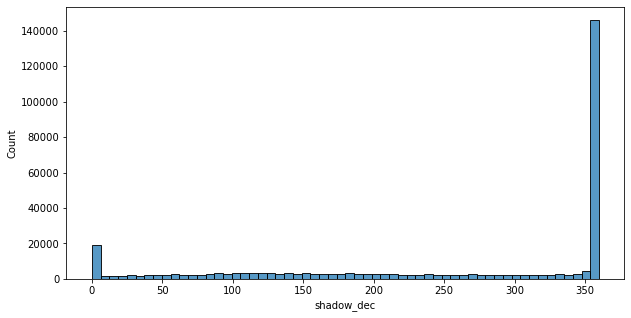

In [20]:
# Let's look at the distribution of the non-failed ones
plt.figure(figsize=(10,5))
sns.histplot(data=brooklyn_data_geo['shadow_dec'], binrange=(0,max(shadows_dec)));

In [21]:
# This seems wrong, but the lack of metadata or much in the way of data description at all is really hampering my ability to figure out in what way or even whether it actually is. 
# The shadow data doesn't give a data resolution, a unit, or any sort of scale. I'm not even sure which end of the scale is which. 
# All I think I have the time and bandwidth to do at this point is run the lookup function as it is and put the derived data into the shape file, noting my reservations about the source

In [22]:
#Moving on to September
shadows_sep = []
for centroid in brooklyn_data_geo['centroid']:
    try:
        shadow = getShadow(path="../data/Shadows/slippy-nyc-sep-22", lat=centroid.y, lon=centroid.x)
        shadows_sep.append(shadow)
    except:
        shadows_sep.append(-40000)

In [23]:
brooklyn_data_geo['shadow_sep'] = shadows_sep

In [24]:
#Moving on to June
shadows_jun = []
for centroid in brooklyn_data_geo['centroid']:
    try:
        shadow = getShadow(path="../data/Shadows/slippy-nyc-june-21", lat=centroid.y, lon=centroid.x)
        shadows_jun.append(shadow)
    except:
        shadows_jun.append(-40000)

In [25]:
brooklyn_data_geo['shadow_jun'] = shadows_jun

In [26]:
# Well, the data's in there at least
brooklyn_data_geo.head()

,address_id,bin,borocode,date_creat,time_creat,full_stree,h_no,hn_rng,hn_rng_suf,hno_suffix,hyphen_typ,date_modif,time_modif,physicalid,post_direc,post_modif,post_type,pre_direct,pre_modifi,pre_type,side_of_st,special_co,st_name,zipcode,base_bbl,cnstrct_yr,doitt_id,feat_code,geomsource,groundelev,heightroof,date_lstmo,time_lstmo,lststatype,mpluto_bbl,name,shape_area,shape_len,geometry,centroid,shadow_dec,shadow_sep,shadow_jun
0,3002257.0,3001479.0,3,2009-02-13,00:00:00.000,COLUMBIA HTS,25,None,None,None,N,2016-09-09,00:00:00.000,100296.0,None,None,HTS,None,None,None,1,V,COLUMBIA,11201,3002040001,1924.0,318201.0,2100.0,Photogramm,28.0,143.374389,2017-08-22,00:00:00.000,Constructed,3002040001,None,27247.461587,878.921970,"POLYGON ((-73.99442 40.70207, -73.99440 40.702...",POINT (-73.99387 40.70195),360,538,718
1,5125956.0,3332515.0,3,2011-08-09,00:00:00.000,1 AVE,5100,None,None,None,N,2015-10-01,00:00:00.000,42327.0,None,None,AVE,None,None,None,2,V,1,11232,3008030005,1931.0,82649.0,2100.0,Photogramm,17.0,28.780000,2017-08-22,00:00:00.000,Constructed,3008030005,None,81267.843494,1379.939037,"POLYGON ((-74.02089 40.65036, -74.02082 40.650...",POINT (-74.02082 40.65007),251,95,21
2,5126065.0,3246020.0,3,2011-08-12,00:00:00.000,W END AVE,177,None,None,A,N,2015-10-01,00:00:00.000,98122.0,None,None,AVE,W,None,None,1,V,END,11235,3087320114,1920.0,632731.0,2100.0,Photogramm,7.0,18.930000,2017-08-22,00:00:00.000,Constructed,3087320114,None,871.096641,128.835025,"POLYGON ((-73.95261 40.57757, -73.95267 40.577...",POINT (-73.95267 40.57758),360,540,720
3,5126067.0,3245988.0,3,2011-08-12,00:00:00.000,W END AVE,177,None,None,B,N,2015-10-01,00:00:00.000,98122.0,None,None,AVE,W,None,None,1,V,END,11235,3087320015,1920.0,755083.0,2100.0,Photogramm,7.0,18.700000,2017-08-22,00:00:00.000,Constructed,3087320015,None,769.542259,117.193081,"POLYGON ((-73.95251 40.57754, -73.95260 40.577...",POINT (-73.95256 40.57758),129,152,325
4,5136408.0,3247656.0,3,2012-08-27,00:00:00.000,EMMONS AVE,3047,None,None,A,N,2015-10-01,00:00:00.000,98154.0,None,None,AVE,None,None,None,2,V,EMMONS,11235,3087970065,1931.0,35118.0,2100.0,Photogramm,8.0,24.139143,2017-08-22,00:00:00.000,Constructed,3087970065,None,2264.424891,242.002301,"POLYGON ((-73.93697 40.58413, -73.93697 40.584...",POINT (-73.93704 40.58428),360,540,720


In [27]:
# Let's see how many rows have a failure value in them
dec_fails = brooklyn_data_geo['shadow_dec'][brooklyn_data_geo['shadow_dec'] == -40000].count()
sep_fails = brooklyn_data_geo['shadow_sep'][brooklyn_data_geo['shadow_sep'] == -40000].count()
jun_fails = brooklyn_data_geo['shadow_jun'][brooklyn_data_geo['shadow_jun'] == -40000].count()
print(dec_fails, sep_fails, jun_fails)

527 527 527


In [28]:
# Same number in every season, so it's probably the same values failing every time. Let's see...
brooklyn_data_geo[(brooklyn_data_geo['shadow_dec'] == -40000) & (brooklyn_data_geo['shadow_sep'] == -40000) & (brooklyn_data_geo['shadow_jun'] == -40000)].shape

(527, 43)

In [29]:
# For some reason the same 527 values are failing to get a shadow result in all three datasets. 
# For the version of the data incorporating shadow data, I think it would be best to drop these rows. 
shadow_data = brooklyn_data_geo.drop(brooklyn_data_geo[brooklyn_data_geo['shadow_dec'] == -40000].index)

In [30]:
shadow_data.shape

(307558, 43)

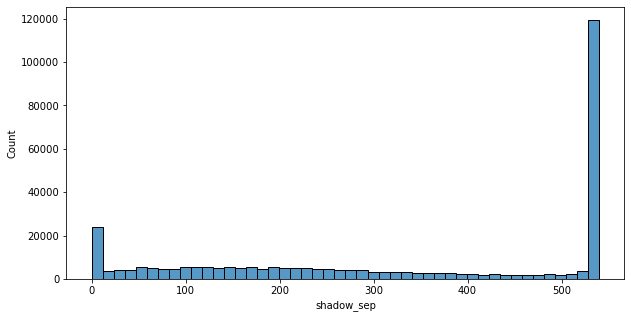

In [31]:
# Making a quick histogram of the September distribution
plt.figure(figsize=(10,5))
sns.histplot(data=brooklyn_data_geo['shadow_sep'], binrange=(0,max(shadows_sep)));

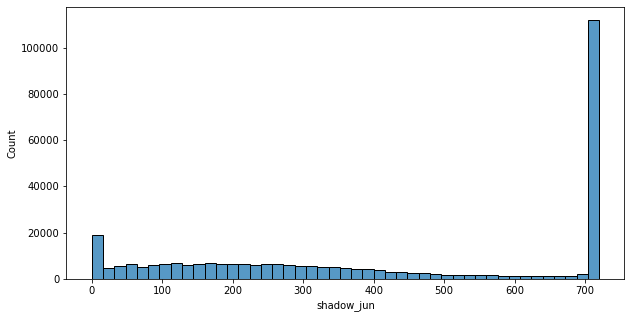

In [32]:
# And again, of the June distribution
plt.figure(figsize=(10,5))
sns.histplot(data=brooklyn_data_geo['shadow_jun'], binrange=(0,max(shadows_jun)));

In [33]:
# Writing back out to a csv
shadow_data.to_csv("../data/shadow_data.csv", index=False)